# DINEOF

In [1]:
import autoroot
import numpyro
import numpyro.distributions as dist
from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
import numpy as np
import jax.random as jr
import xarray_einstats
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import xarray as xr
import pandas as pd
import einx
from tqdm.auto import trange, tqdm

key = jr.key(123)

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.75)


%matplotlib inline

%load_ext autoreload
%autoreload 2

## Data

In [2]:
ds = xr.tutorial.open_dataset("air_temperature")
ds

<xarray.Dataset> Size: 31MB
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float64 31MB ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [3]:
def calculate_dt(ds: xr.Dataset) -> xr.Dataset:
    return ds.time.diff("time")

In [4]:
calculate_dt(ds).values

array([21600000000000, 21600000000000, 21600000000000, ...,
       21600000000000, 21600000000000, 21600000000000],
      dtype='timedelta64[ns]')

In [5]:
# change units
# ds = ds.sel(time=slice("2013-01-01", "2013-02-01"))
ds["air"] = ds.air - 273.15

### Rearrange Data

In [6]:
# tranpose
ds = ds.transpose("time", "lon", "lat")
data = ds.air.stack(spatial=["lon", "lat"])
data = data.transpose("spatial", "time")

In [7]:
n_space = data.spatial.shape[0]
n_time = data.time.shape[0]

## Model

In [8]:
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
from jaxtyping import Float, Array

In [9]:
n_space, n_time

(1325, 2920)

In [10]:
from typing import Optional
import equinox as eqx

class PPCA(eqx.Module):

    num_features: int
    num_latent: int

    def model(self, y: Float[Array, "N Dy"], batch_size: Optional[int]=None):

        # calculate alpha, prior for weights
        rate: Float[Array, "d"] = jnp.ones(shape=(self.num_latent,))
        alpha_w: Float[Array, "d"] = numpyro.sample("alpha_w", dist.Exponential(rate=rate).to_event(1))
        
        # calculate W
        loc: Float[Array, "D"] = jnp.zeros(shape=(self.num_features, self.num_latent))
        scale: Float[Array, "D D"] = einx.rearrange("d -> D d", alpha_w, D=self.num_features)
        
        W: Float[Array, "D d"] = numpyro.sample("W", dist.Normal(loc, scale).to_event(1))

        # # calculate mu
        # loc: Float[Array, "D"] = jnp.zeros(shape=(self.num_features,))
        # rate: Float[Array, "D"] = jnp.ones(shape=(self.num_features,))
        # alpha_mu: Float[Array, "D"] = numpyro.sample("alpha_mu", dist.Exponential(rate=rate).to_event(1))
        # mu: Float[Array, "D"] = numpyro.sample("mu", dist.Normal(loc, alpha_mu).to_event(1))

        # calculate scale
        sigma: Float[Array, ""] = numpyro.sample("sigma", dist.HalfCauchy(scale=1))

        # # latent variable
        loc = jnp.zeros(shape=(self.num_latent,))
        scale = jnp.ones(shape=(self.num_latent,))

        with numpyro.plate("samples", y.shape[0]):

            # batch size
            batch_y = numpyro.subsample(y, event_dim=1) if y is not None else None

            z: Float[Array, "Dz"] = numpyro.sample("z", dist.Normal(loc, scale).to_event(1))
            
            # calculate mean
            loc: Float[Array, "B D"] = einx.dot("D d, B d -> B D", W, z) 
            # loc: Float[Array, "B D"] = einx.add("B D, D -> B D", loc, mu)
            
            # calculate scale
            scale: Float[Array, "D"] = sigma * jnp.ones(shape=(self.num_features,))

            # data likelihood
            d = dist.Normal(loc=loc, scale=scale).to_event(1)
            y = numpyro.sample("y", d, obs=batch_y)

        return y

In [11]:
from numpyro.infer.autoguide import AutoDelta, AutoNormal
from numpyro.infer import Predictive, SVI, Trace_ELBO, TraceMeanField_ELBO
import jax.random as jrandom

In [12]:
ppca_model = PPCA(num_latent=25, num_features=n_time)

In [13]:
with numpyro.handlers.seed(rng_seed=jrandom.PRNGKey(42)):
    out = ppca_model.model(y=data.values[:32])
    print(out.shape)

(32, 2920)


In [14]:
# initialize MAP guide
map_guide = AutoDelta(ppca_model.model)

# initialize svi inference
loss = TraceMeanField_ELBO()
optimizer = numpyro.optim.Adam(step_size=0.01)
svi = SVI(model=ppca_model.model, guide=map_guide, optim=optimizer, loss=loss)

num_samples: int = 1
num_steps: int = 3_000
rng_key = jrandom.PRNGKey(123)
batch_size = 128
init_params = None
svi_result = svi.run(rng_key=rng_key, init_params=init_params, num_steps=num_steps, y=data.values, batch_size=batch_size)

100%|████████████████████| 3000/3000 [02:20<00:00, 21.30it/s, init loss: 546254430.6324, avg. loss [2851-3000]: 8012829.1471]


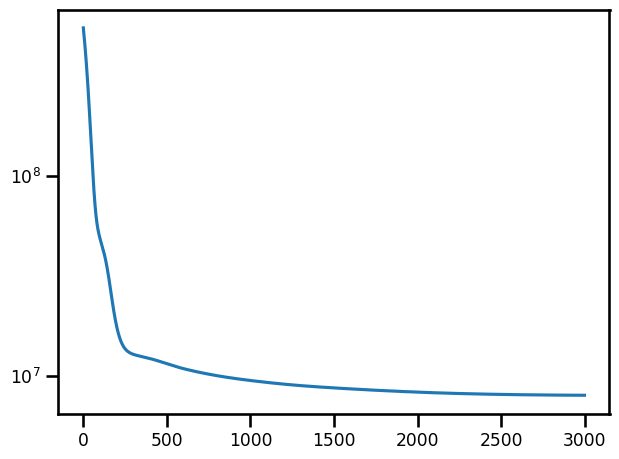

In [15]:
fig, ax = plt.subplots()
ax.plot(svi_result.losses)
ax.set(yscale="symlog")
plt.tight_layout()
plt.show()

## Inference

#### Variational Parameters

In [16]:
from numpyro.infer import Predictive

In [17]:
params = svi_result.params

In [18]:
list(params.keys())

['W_auto_loc', 'alpha_w_auto_loc', 'sigma_auto_loc', 'z_auto_loc']

In [19]:
params["W_auto_loc"].shape

(2920, 25)

#### Posterior Parameters

In [20]:
predictive = Predictive(model=ppca_model.model, guide=map_guide, params=params, num_samples=1, return_sites=["W", "z", "mu"])
predictive = Predictive(map_guide, params=params, num_samples=1, return_sites=["W", "z", "mu"])
posterior_samples = predictive(jrandom.PRNGKey(0), y=data.values)

In [21]:
posterior_samples["z"].shape

(1, 1325, 25)

In [22]:
# posterior_samples["mu"].shape, X_recon.shape

In [23]:
posterior_samples["W"].shape

(1, 2920, 25)

In [24]:
X_recon = einx.dot("B Dt Dz, B Ds Dz -> Ds Dt", posterior_samples["W"], posterior_samples["z"])
# X_recon = einx.add("Ds Dt, Dt -> Ds Dt", X_recon, posterior_samples["mu"].squeeze())
X_recon.shape

(1325, 2920)

In [25]:
# data["mean_field"] = (("time",), posterior_samples["mu"].squeeze())

In [26]:
# data.mean_field.unstack().plot()#.pcolormesh(x="time")

In [27]:
data["recon"] = (("spatial", "time"), X_recon)

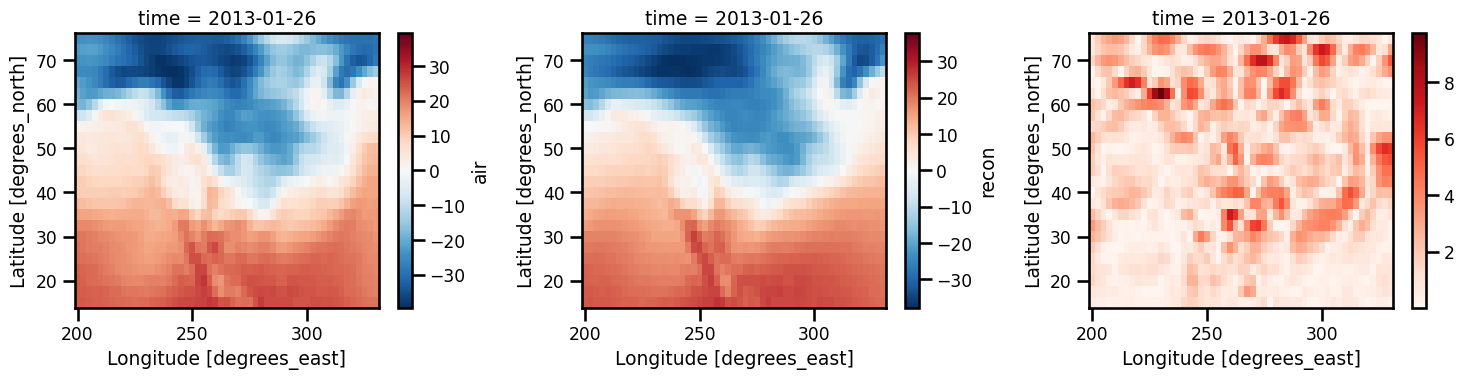

In [28]:
fig, ax = plt.subplots(ncols=3, figsize=(15,4))

itime = 100

data.unstack().isel(time=itime).plot.pcolormesh(x="lon", ax=ax[0])
data.recon.unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[1])
np.abs(data - data.recon).unstack().isel(time=itime).plot.pcolormesh(x="lon",ax=ax[2],cmap="Reds")

plt.tight_layout()
plt.show()